In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    PolynomialPredictor,
    ExponentialScatteringModel,
    ObservingMetadata,
    Time,
    cycfold_gpu,
    guppi_raw,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


<IPython.core.display.Javascript object>


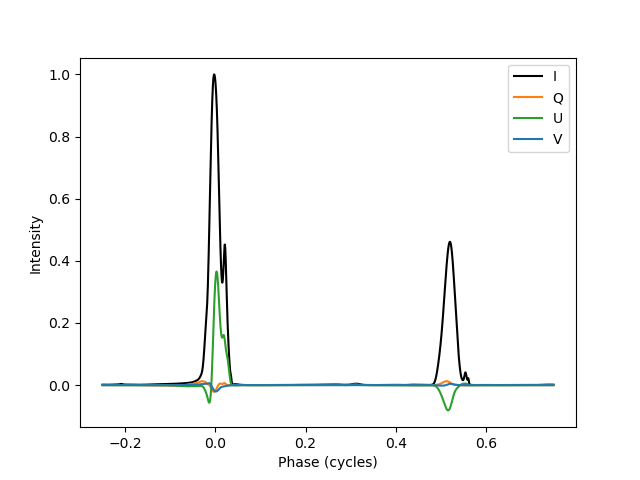

In [3]:
template.plot(what='IQUV', shift=0.25)
plt.show()

In [4]:
metadata = ObservingMetadata.from_file(template_file)
metadata.observer = "cycspec-simulator"

In [5]:
nchan = 2
chan_bw = 1.5625e6 # Hz
obsfreq = 1.5e9 # Hz
#pulse_freq = 641.948222127829 # Hz
#predictor = FreqOnlyPredictor(pulse_freq, epoch=Time(60000, 0, 0))
predictor = PolynomialPredictor.from_file("polyco-B1937+21-60000.dat")
model = BasebandModel(template, nchan=nchan, chan_bw=chan_bw, predictor=predictor, obsfreq=obsfreq)

In [6]:
scattering_model = ExponentialScatteringModel(
    scattering_time=40e-6, nchan=nchan, chan_bw=model.chan_bw, obsfreq=obsfreq, cutoff=20
)
pattern = scattering_model.realize()

<IPython.core.display.Javascript object>


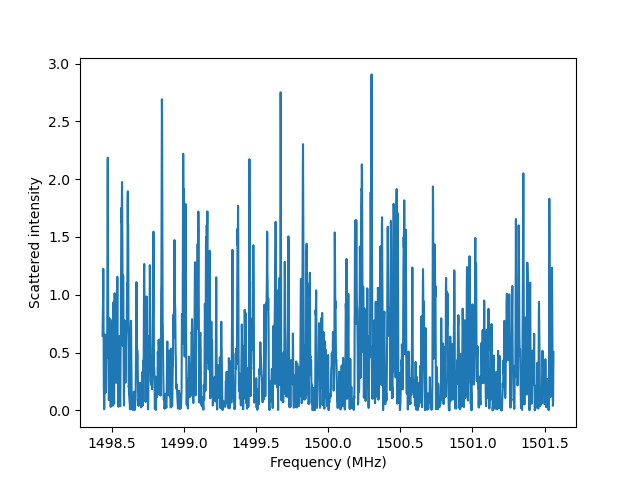

In [7]:
pattern.plot_scattered_intensity()
plt.show()

In [8]:
t_start = Time(60000, 1800, -(pattern.impulse_response.shape[-1]-1)/chan_bw)
data = model.sample(2**22 + pattern.impulse_response.shape[-1] - 1, t_start=t_start)
data = pattern.scatter(data)

In [10]:
%time pspec = cycfold_gpu(data, 1024, 1024, predictor)

CPU times: user 3.73 s, sys: 505 ms, total: 4.24 s
Wall time: 4.27 s


<IPython.core.display.Javascript object>


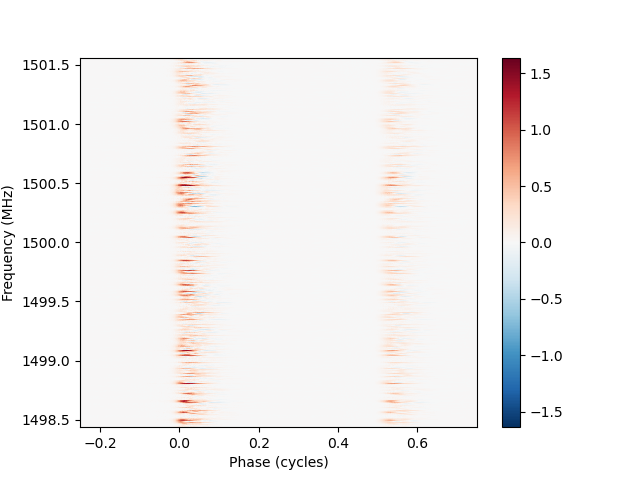

In [12]:
pc = pspec.plot(shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.show()